**References:**

1. https://keras.io/api/applications/
2. https://keras.io/guides/transfer_learning/

In [1]:
!nvidia-smi

Wed Aug 18 01:32:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

P100

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/MyDrive/SVNCKH'
! ls

/content/gdrive/MyDrive/SVNCKH
Database		     train_accuracy_01.png  valid_accuracy_01.png
Feature_extraction_01.ipynb  train_accuracy_02.png  valid_accuracy_02.png
Feature_extraction_02.ipynb  train_loss_01.png	    valid_loss_01.png
Feature_extraction_04.ipynb  train_loss_02.png	    valid_loss_02.png


In [5]:
# import the basic libraries
import numpy as np
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Flatten, Reshape, ReLU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import GlobalAveragePooling2D, Concatenate, Lambda, add
#from keras.optimizers import Adam, RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from glob import glob

**DenseNet121**

In [6]:
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/SVNCKH/Database/train'
valid_path = '/content/gdrive/MyDrive/SVNCKH/Database/valid'
test_path = '/content/gdrive/MyDrive/SVNCKH/Database/test'

In [7]:
# add preprocessing layer to the front of DenseNet
densenet_adam = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

29097984/29084464 [==============================] - 0s 0us/step


In [8]:
# don't train existing weights
for layer in densenet_adam.layers:
  layer.trainable = False

In [9]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/SVNCKH/Database/train/*')

In [10]:
# our layers - you can add more if you want
x = Flatten()(densenet_adam.output)

In [11]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [12]:
# create a model object
model = Model(inputs=densenet_adam.input, outputs=prediction)

In [13]:
# view the structure of the model
#model.summary()

In [14]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [15]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            shuffle = False,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 1260 images belonging to 6 classes.
Found 270 images belonging to 6 classes.
Found 270 images belonging to 6 classes.


In [22]:
# fit the model
densenet_adam = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=1,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

20/20 [==============================] - 15s 768ms/step - loss: 6.1729e-04 - accuracy: 1.0000 - val_loss: 0.0256 - val_accuracy: 0.9926


In [23]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.0410
Test accuracy: 0.9926


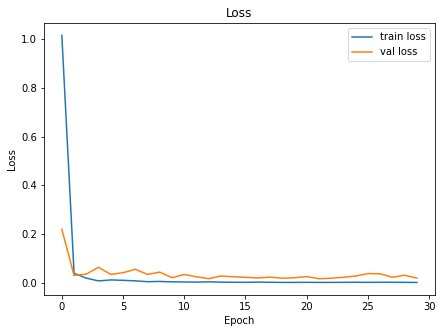

In [18]:
# loss
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
plt.plot(densenet_adam.history['loss'], label='train loss')
plt.plot(densenet_adam.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
fig.savefig('loss_densenet_adam')

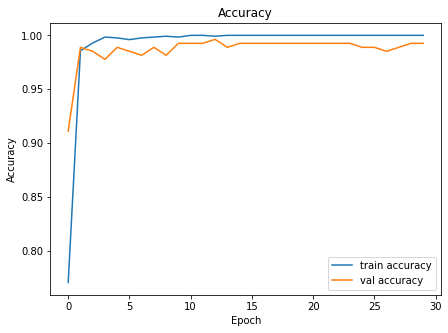

In [19]:
# accuracy
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
plt.plot(densenet_adam.history['accuracy'], label='train accuracy')
plt.plot(densenet_adam.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
fig.savefig('accuracy_densenet_adam')

**Confusion matrix:**

In [24]:
#importing confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
Y_pred = model.predict(x=test_set, steps=len(test_set), verbose=0)

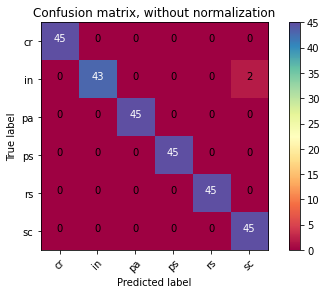

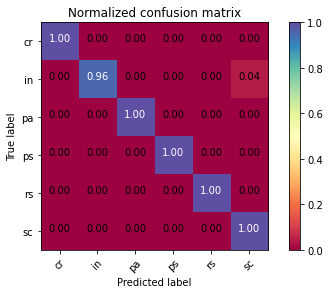

In [26]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Spectral):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm = confusion_matrix(y_true = test_set.classes, y_pred = np.argmax(Y_pred, axis = -1))
# Plot non-normalized confusion matrix
class_names = ['cr', 'in', 'pa', 'ps', 'rs', 'sc']
plt.figure()
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [27]:
#Confution Matrix and Classification Report
y_true = test_set.classes
Y_pred = model.predict(test_set, len(test_set))
y_pred = np.argmax(Y_pred, axis = 1)
print('Confusion Matrix\n')
print(confusion_matrix(y_true, y_pred))
print('\nClassification Report\n')
target_names = ['cr', 'in', 'pa', 'ps', 'rs', 'sc']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Confusion Matrix

[[45  0  0  0  0  0]
 [ 0 43  0  0  0  2]
 [ 0  0 45  0  0  0]
 [ 0  0  0 45  0  0]
 [ 0  0  0  0 45  0]
 [ 0  0  0  0  0 45]]

Classification Report

              precision    recall  f1-score   support

          cr       1.00      1.00      1.00        45
          in       1.00      0.96      0.98        45
          pa       1.00      1.00      1.00        45
          ps       1.00      1.00      1.00        45
          rs       1.00      1.00      1.00        45
          sc       0.96      1.00      0.98        45

    accuracy                           0.99       270
   macro avg       0.99      0.99      0.99       270
weighted avg       0.99      0.99      0.99       270



In [28]:
#one-hot

y_true = y_true.astype('uint8')
y_pred = y_pred.astype('uint8')

k = 6

def convert_one_hot(y, k):
    one_hot = np.zeros((len(y), k))
    one_hot[np.arange(len(y)), y] = 1
    return one_hot

y_true = convert_one_hot(y_true, 6)
y_pred = convert_one_hot(y_pred, 6)

#print(y_true)
#print(y_pred)

**ROC_AUC_on_Multiclass_classification**

In [29]:
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# 3 classes to classify
n_classes = 6

# Plot linewidth.
lw = 2

In [30]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  del sys.path[0]


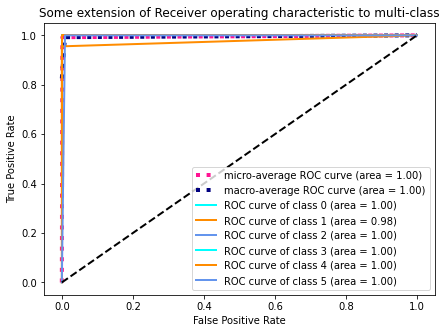

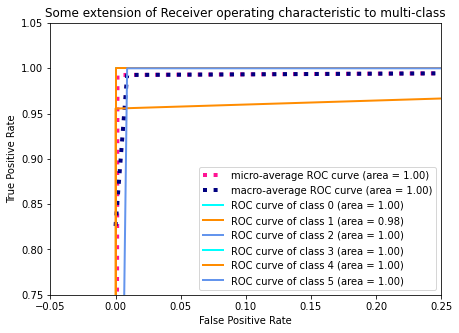

In [31]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
fig.savefig('Some extension of Receiver operating characteristic to multi-class_0')

# Zoom in view of the upper left corner.
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
plt.xlim(-0.05, 0.25)
plt.ylim(0.75, 1.05)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
fig.savefig('Some extension of Receiver operating characteristic to multi-class_1')

**The average precision score in multi-label settings**

In [32]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i],
                                                        y_pred[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(),
    y_pred.ravel())
average_precision["micro"] = average_precision_score(y_true, y_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.99


**Precision-Recall**

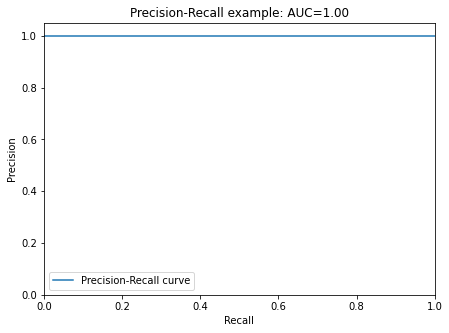

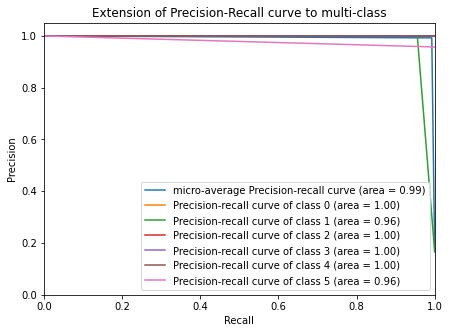

In [33]:
# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i],
                                                        y_pred[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])

# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(),
    y_pred.ravel())
average_precision["micro"] = average_precision_score(y_true, y_pred,
                                                     average="micro")

# Plot Precision-Recall curve
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
plt.plot(recall[0], precision[0], label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
plt.legend(loc="lower left")
fig.savefig('Precision-Recall curve')

# Plot Precision-Recall curve for each class
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
plt.plot(recall["micro"], precision["micro"],
         label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
for i in range(n_classes):
    plt.plot(recall[i], precision[i],
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(i, average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
fig.savefig('Extension of Precision-Recall curve to multi-class')